In [4]:
# # aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [6]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from guara.modeling.supervised_modelz import SupervisedModelz

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data

In [7]:
# carregar dataset Laudo_classificacao_2020.xlsx como df
df =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Laudo_classificacao_2020.xlsx', engine='openpyxl')
df.columns = df.columns.str.lower()
df.rename(columns={'(1) câncer / (2) não câncer':'cancer', 'texto_diagnostico_resumo':'resumo'}, inplace=True)

In [8]:
df.head()

,rgh,identificador,laudo,data,resumo,cancer
0,1341,3004888942H20-028890,H20-028890,2020-11-12,[* Pólipo endometrial sem atipias.],2
1,3166,3003664904H20-013662,H20-013662,2020-06-29,[*Adenocarcinoma endometrioide de endométrio c...,1
2,3166,2003793224H20-014936,H20-014936,2020-07-20,[* Adenocarcinoma endometrioide do endométrio ...,1
3,4448,3004533927H20-024222,H20-024222,2020-10-07,"[* Pólipo endocervical sem atipias., * Pólipo ...",2
4,6220,1003913311H20-016310,H20-016310,2020-07-31,[* Pólipo endocervical sem atipias com metapla...,2


In [9]:
df.laudo.apply(lambda x: x[:3]).value_counts()

H20    6807
Name: laudo, dtype: int64

In [10]:
# carregar 6ce86244-be08-4bb2-9919-9c3562c3b1d9.parquet como laudos
laudos = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/6ce86244-be08-4bb2-9919-9c3562c3b1d9.parquet')
laudos.columns = laudos.columns.str.lower()
laudos.rename(columns={'testodiagnosi':'texto'}, inplace=True)

In [11]:
laudos.head()

,rgh,contatore,paziente,laudo,texto
0,*,526184,219442,H20-014998,1 Biópsia de pulmão direito: * Fragmento de ...
1,*,574912,230269,H21-008467,1 Biópsia de lesão endobrônquica do lobo infer...
2,",0.++++++++++++.02++16014853",535735,217373,C20-007815,<NA>
3,",23A13864380",532955,92595,C20-007146,<NA>
4,>:,528173,218817,H20-016077,1 Mastectomia à direita Lesão 1 * Carcinom...


In [12]:
# juntar df e laudos pela coluna laudo
full_df = pd.merge(left=df, right=laudos, on=['laudo'], how='inner')

In [13]:
# filtrar o dataframe: colunas = [df.id, laudo.laudo, df.rotulo]
full_df = full_df#[['laudo','texto','cancer']]
full_df['cancer'] = abs(full_df['cancer']-2)
full_df.head()

,rgh_x,identificador,laudo,data,resumo,cancer,rgh_y,contatore,paziente,texto
0,10014,2004487509H20-023542,H20-023542,2020-09-29,[* Pólipos de glândulas fúndicas.],0,10014,540524,28094,1 Pólipos gástricos * Pólipos de glândulas fú...
1,11428,1003815788H20-015172,H20-015172,2020-07-21,"[* Fibrose dérmica cicatricial., * Tecido fibr...",1,11428,526498,50759,1 Cicatriz prévia * Fibrose dérmica cicatrici...
2,1000187,2004090597H20-018540,H20-018540,2020-08-15,[* Adenoma tubular com displasia de baixo grau.],0,1000187,532284,112998,1 Pólipo séssil de cólon ascendente (4 mm) * ...
3,1002171,3004192434H20-019792,H20-019792,2020-08-31,[* Perifoliculite crônica.],0,1002171,534449,102864,1 Exérese de lesão em região cervical anterior...
4,1002244,3003634333H20-013359,H20-013359,2020-06-25,[* Dermatite perivascular superficial espongió...,0,1002244,523236,15612,1 Biópsia incisional de lesão de pele em pé es...


# Analise Exploratória

In [14]:
full_df[['texto', 'resumo']].head().values

array([['1 Pólipos gástricos\r\n* Pólipos de glândulas fúndicas.\r\n\r\n. A pesquisa de Helicobacter pylori pela coloração de Giemsa resultou neagativa.',
        '[* Pólipos de glândulas fúndicas.]'],
       ['1 Cicatriz prévia\r\n* Fibrose dérmica cicatricial. \r\n\r\n2 Nódulo mesentérico\r\n* Tecido fibroconjuntivo exibindo extensa ossificação.\r\n\r\n3 Ureter direito \r\n* Lipossarcoma bem diferenciado, variante esclerosante, de baixo grau histológico de malignidade, envolvendo ureter.\r\n\r\n4 Peritôneo pélvico\r\n* Livre de neoplasia.\r\n\r\n5 Músculo psoas distal \r\n* Livre de neoplasia.\r\n\r\n6 Gerota \r\n* Livre de neoplasia\r\n\r\n7 Ressecção de tumor retroperitonial com nefrectomia direita \r\n* Lipossarcoma desdiferenciado, de alto grau histológico de malignidade, residual, acometendo serosa de intestino grosso, apêndice e ureter à direita. \r\n\r\n. Invasão vascular sanguínea: não detectada\r\n. Invasão vascular linfática: não detectada.\r\n. Invasão perineural: não dete

In [15]:
laudos.paziente.value_counts()

127813    28
207063    22
157017    19
29274     19
221656    15
          ..
125450     1
55763      1
231552     1
4227       1
16292      1
Name: paziente, Length: 4543, dtype: Int64

In [16]:
full_df.head()[['texto', 'cancer']].values

array([['1 Pólipos gástricos\r\n* Pólipos de glândulas fúndicas.\r\n\r\n. A pesquisa de Helicobacter pylori pela coloração de Giemsa resultou neagativa.',
        0],
       ['1 Cicatriz prévia\r\n* Fibrose dérmica cicatricial. \r\n\r\n2 Nódulo mesentérico\r\n* Tecido fibroconjuntivo exibindo extensa ossificação.\r\n\r\n3 Ureter direito \r\n* Lipossarcoma bem diferenciado, variante esclerosante, de baixo grau histológico de malignidade, envolvendo ureter.\r\n\r\n4 Peritôneo pélvico\r\n* Livre de neoplasia.\r\n\r\n5 Músculo psoas distal \r\n* Livre de neoplasia.\r\n\r\n6 Gerota \r\n* Livre de neoplasia\r\n\r\n7 Ressecção de tumor retroperitonial com nefrectomia direita \r\n* Lipossarcoma desdiferenciado, de alto grau histológico de malignidade, residual, acometendo serosa de intestino grosso, apêndice e ureter à direita. \r\n\r\n. Invasão vascular sanguínea: não detectada\r\n. Invasão vascular linfática: não detectada.\r\n. Invasão perineural: não detectada.\r\n\r\n* Rim direito sem par

In [17]:
full_df.shape

(1426, 10)

In [18]:
full_df.cancer.value_counts()

0    1072
1     354
Name: cancer, dtype: int64

# Modelagem

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [20]:
import nltk
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.misc import babelize_shell
from unidecode import unidecode
from nltk import tokenize

def processa_texto_(texto, return_ = 'string'):
    # stemmer = nltk.stem.RSLPStemmer()
    stemmer = nltk.stem.SnowballStemmer(language = 'portuguese')
    stopwords=nltk.corpus.stopwords.words('portuguese')
   


    # separa em palavras
    token = tokenize.word_tokenize(texto.lower(), language='portuguese')
    # retira stopwords
    token = [word for word in token if word not in stopwords]
    # retira palavras pre selecionadas
    #token = [word for word in token if len(word) > 2]
    # retira numeros 
    token = [ word if word.isalpha() else '#NUM' for word in token ]
    # tira caracteres especiais  e faz stemmizacao
    token = [unidecode(stemmer.stem(word)) for word in token]



    if return_ == 'string':
        return ' '.join(token)
    elif return_ == 'list':
        return token

    
class ProcessaTexto(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col=col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
     
        X['texto_tratado'] = X[self.col].replace('\§', ' ENTER ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '-'], '', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '\*'], ' ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace([ '\/', '\.', '\,', '\;'], ' punkt ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].apply(lambda x: processa_texto_(x))
        
        return X

In [21]:
class CountVectorizerPandas(BaseEstimator, TransformerMixin):
    """
    Performs bag of words on a column
    args:
        max_features: maximum number of features
    
    """  
    
    def __init__(self, max_features):
        self.cv = None
        self.max_features = max_features
        
    def fit(self, X, y=None):
        
        self.col = 'texto_tratado'
        
        self.cv =  CountVectorizer(max_features=self.max_features)
                           
        self.cv.fit(X[self.col])
        
        return self


    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        
        Xt = self.cv.transform(X[self.col]).todense()
        Xt = pd.DataFrame(Xt, columns = self.cv.get_feature_names(), index=X.index)
        
        return Xt  

In [22]:
# split dos dados - 70% para treino e 30% para validação
x_train, x_test, y_train, y_test = train_test_split(
    full_df[['laudo','texto']], 
    full_df['cancer'], 
    train_size=0.7, 
    shuffle=True,
    random_state=123
    )


# aplicar pipeline com transformações
pipe = Pipeline([
    ('preproc', ProcessaTexto('texto')),
    ('bag', CountVectorizerPandas(max_features=250))
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [29]:
x_train.head()  

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,transica,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
1285,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1039,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [24]:
x_test.head().values

array([[0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [25]:
y_test.values

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

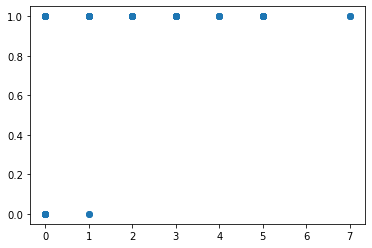

In [26]:
plt.scatter(x_train.carcinom, y_train)

In [27]:
carc = pd.DataFrame({'carcinoma':x_test.carcinom, 'cancer': y_test, 'count':[1]*len(y_test)})
carc.groupby([ 'cancer','carcinoma']).count()

count
cancer carcinoma       
0      0            328
       1              1
1      0             19
       1             56
       2             11
       3              4
       4              4
       5              5

In [28]:
carc = pd.DataFrame({'neoplas':x_test.neoplas, 'cancer': y_test, 'count':[1]*len(y_test)})
carc.groupby([ 'cancer','neoplas']).count()

count
cancer neoplas       
0      0          308
       1           13
       2            3
       4            1
       6            2
       13           1
       17           1
1      0           41
       1           12
       2           15
       3            5
       4            9
       5            2
       6            7
       7            2
       8            1
       9            2
       11           1
       13           1
       14           1

In [30]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ', y_test.shape)

x_train shape:  (998, 250) y_train shape:  (998,)
x_test shape:  (428, 250) y_test shape:  (428,)


In [31]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

params = {
    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': 20,
    'n_estimators': 500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
 }

model = md.fit(x_train, x_test, y_train, y_test, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 255, number of negative: 743
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 998, number of used features: 216
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255511 -> initscore=-1.069432
[LightGBM] [Info] Start training from score -1.069432


Found `n_estimators` in params. Will use it instead of argument


Modelo treinado em 0.01 minutos 



Model best iteration: 500

BINARY_LOGLOSS loss:
Train: 0.0305
Val  : 0.0756


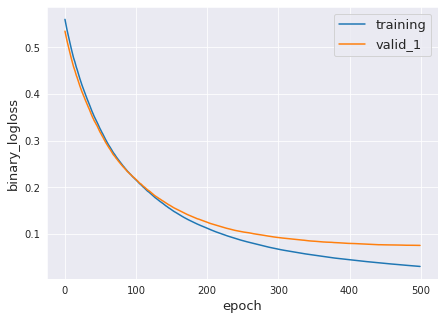

In [32]:
md.plot_train_info()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


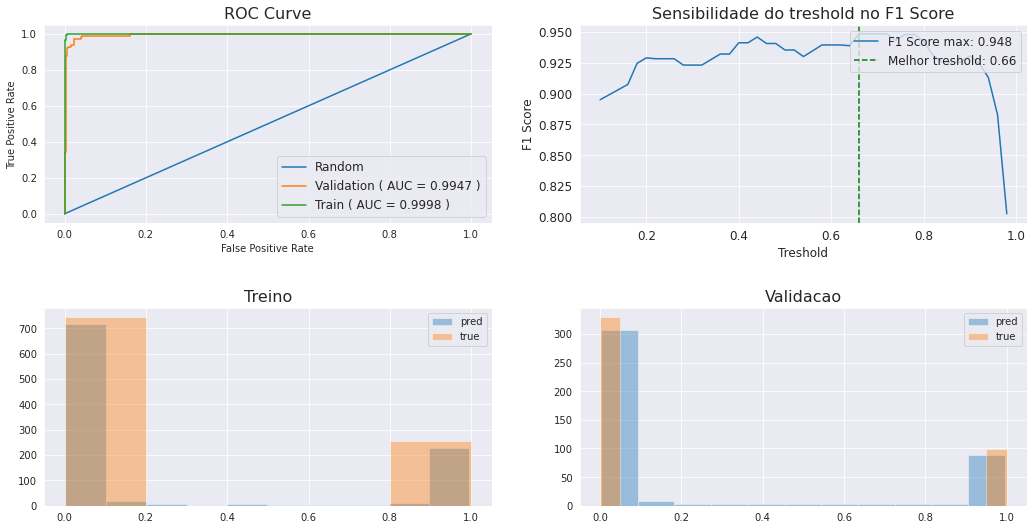

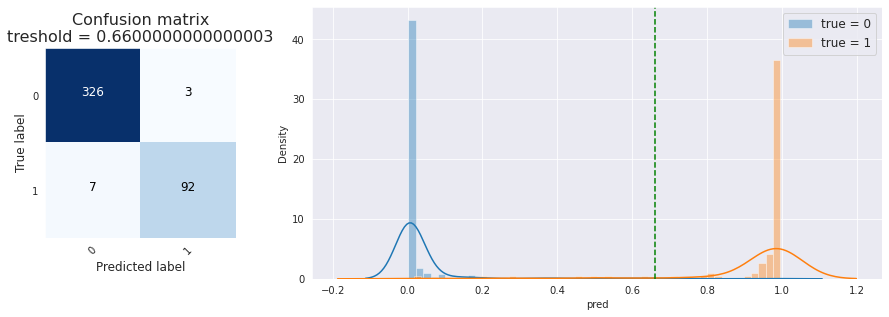


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       329
           1       0.97      0.93      0.95        99

    accuracy                           0.98       428
   macro avg       0.97      0.96      0.97       428
weighted avg       0.98      0.98      0.98       428



In [33]:
ytrain_pred = md.predict(x_train)
yval_pred = md.predict(x_test)

md.evaluation_plots(y_train.values, ytrain_pred, y_test.values, yval_pred)

In [34]:
# shap
df_shap = md.init_shap(x_test)

df_shap.head()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,transica,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
0,0.0,0.012286,0.0,0.0,-0.000448,-0.095107,0.002829,0.0,0.000435,0.0,...,0.0,0.000084,-0.000028,-0.032602,-0.009399,0.0,0.0,0.0,-0.000923,0.000515
1,0.0,0.013785,0.0,0.0,-0.000448,-0.093133,0.069142,0.0,0.000435,0.0,...,0.0,-0.000279,0.062166,-0.031341,-0.008607,0.0,0.0,0.0,-0.000923,0.000515
2,0.0,0.013785,0.0,0.0,-0.000448,-0.092085,0.069142,0.0,0.000435,0.0,...,0.0,-0.000954,0.062166,-0.031341,-0.008607,0.0,0.0,0.0,-0.000923,0.000515
3,0.0,0.027461,0.0,0.0,-0.000077,-0.035905,0.002214,0.0,-0.000071,0.0,...,0.0,0.000095,0.001022,-0.010836,-0.002986,0.0,0.0,0.0,-0.006473,0.001610
4,0.0,0.024308,0.0,0.0,-0.000206,-0.063186,0.009003,0.0,0.000280,0.0,...,0.0,0.000591,0.011217,-0.018952,-0.004767,0.0,0.0,0.0,-0.000923,0.000515


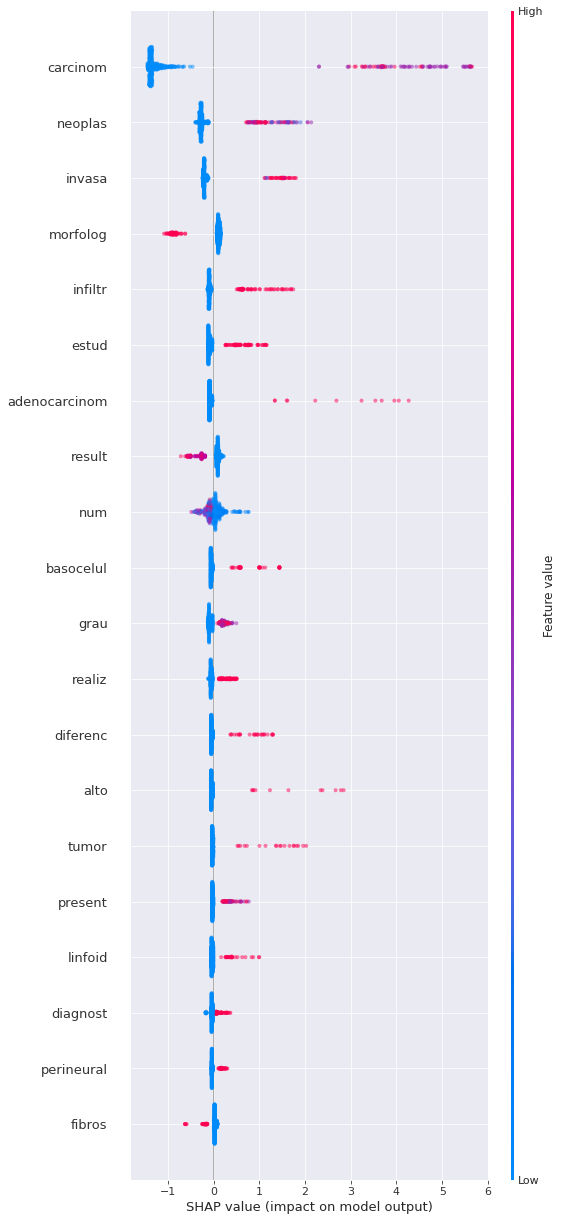

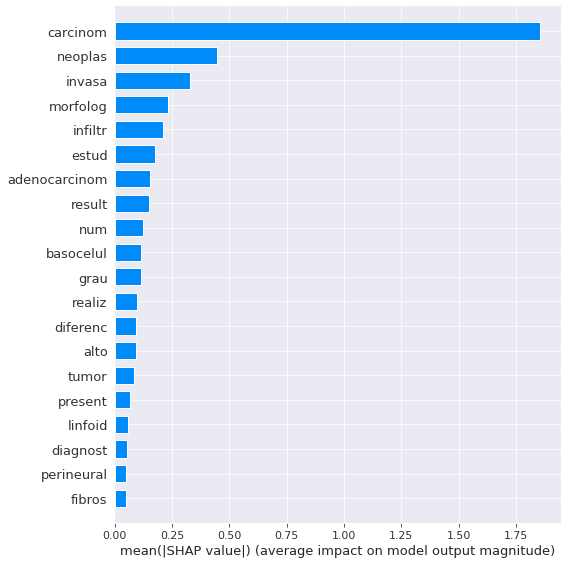

In [35]:
importance = md.shap_importance(x_test)

In [36]:
importance

carcinom      1.854690
neoplas       0.445740
invasa        0.327917
morfolog      0.230886
infiltr       0.211927
                ...   
intens        0.000000
inflamator    0.000000
inferior      0.000000
incisur       0.000000
acentu        0.000000
Length: 250, dtype: float64